<a href="https://colab.research.google.com/github/BennettHilck12/DraftEdge/blob/main/DraftEdge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS 5450 Final Project: DraftEdge

##### Bennett Hilck, Ethan Xia, Mohammed Soufan


# Part 1: Introduction



For our final project, we sought to better understand how NBA teams can draft players more effectively by predicting which NCAA D1 prospects are most likely to outperform expectations at the professional level. To pursue this goal, we compiled and analyzed several datasets containing college performance statistics, NBA Combine measurements and performance statistics, and eventual NBA outcomes.


By aggregrating and merging these data sources, we aim to identify advanced or undervalued metrics that may be overlook in traditional scouting evaluations. This approach alows us to quantitatvely asses why certain highly drafted players become "busts," while others selected later dramatically exceed their draft position.


Given the high variance and high cost associated with drafting, our project highlights non-obvious predictors that could help inform more data-driven decision-making and potentially reshape how teams and scouts approach future NBA drafts.


We hope that you find our project impactful!

# Part 2: Data Loading & Preprocessing


First, we must import all relevant libraries for our project. We will use all supplemental libraries throughout our project.

In [1]:
# Imports + Installs
!pip install category_encoders
import pandas as pd
import seaborn as sns
import dask.dataframe as dd
import matplotlib.pyplot as plt
import folium
import numpy as np
import category_encoders as ce
import dask.array as da
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tqdm
import copy
from xgboost import XGBRegressor
from folium.plugins import HeatMap
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
from sklearn import datasets, linear_model
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from torch.utils import data as data_utils
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 2.8 MB/s eta 0:00:00


## 2.1 Data Mounting + Storage

Because our datasets are quite large, often containing thousands of player seasons, detailed college statistics, and multiple years of NBA Combine measurements—we decided to upload them to Google Drive rather than store them locally. This allows us to efficiently access and manage the data from within our notebook environment without running into storage limitations or upload constraints. Hosting the data on Google Drive also ensures easier collaboration, as all team members can work from the same centralized, version-consistent files.

In [2]:
# Data Loading via Google Docs
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2.2 Loading + Preprocessing NBA Combine Data

First, let's load in our data from the NBA combine.

In [3]:
file_path = '/content/drive/MyDrive/final_project_datasets/draft_combine_stats.csv'
combine_df = pd.read_csv(file_path)
display(combine_df.head(10))

,season,player_id,first_name,last_name,player_name,position,height_wo_shoes,height_wo_shoes_ft_in,height_w_shoes,height_w_shoes_ft_in,...,spot_nba_break_right,spot_nba_corner_right,off_drib_fifteen_break_left,off_drib_fifteen_top_key,off_drib_fifteen_break_right,off_drib_college_break_left,off_drib_college_top_key,off_drib_college_break_right,on_move_fifteen,on_move_college
0,2001,12033,Adam,Allenspach,Adam Allenspach,C,83.50,6' 11.5'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2001,2240,Gilbert,Arenas,Gilbert Arenas,SG,74.25,6' 2.25'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2001,2220,Brandon,Armstrong,Brandon Armstrong,SG,75.50,6' 3.5'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2001,2203,Shane,Battier,Shane Battier,SF-PF,80.25,6' 8.25'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2001,12034,Cookie,Belcher,Cookie Belcher,SG-PG,75.00,6' 3'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2001,2294,Charlie,Bell,Charlie Bell,PG,74.50,6' 2.5'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2001,2257,Ruben,Boumtje-Boumtje,Ruben Boumtje-Boumtje,C,83.50,6' 11.5'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2001,12035,Calvin,Bowman,Calvin Bowman,PF,80.75,6' 8.75'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2001,2214,Michael,Bradley,Michael Bradley,PF,81.50,6' 9.5'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2001,2249,Jamison,Brewer,Jamison Brewer,PG,74.50,6' 2.5'',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
combine_df.dtypes

,0
season,int64
player_id,int64
first_name,object
last_name,object
player_name,object
position,object
height_wo_shoes,float64
height_wo_shoes_ft_in,object
height_w_shoes,float64
height_w_shoes_ft_in,object


In [5]:
combine_df.describe()

,season,player_id,height_wo_shoes,height_w_shoes,weight,wingspan,standing_reach,body_fat_pct,hand_length,hand_width,standing_vertical_leap,max_vertical_leap,lane_agility_time,modified_lane_agility_time,three_quarter_sprint,bench_press
count,1202.000000,1.202000e+03,1153.000000,1008.000000,1152.000000,1153.000000,1152.000000,1003.000000,719.000000,719.000000,1017.000000,1017.000000,1008.000000,411.000000,1012.000000,808.000000
mean,2012.536606,2.350133e+06,77.570902,78.796577,214.902604,82.478187,103.593663,7.352313,8.720793,9.448887,29.240167,34.637168,11.384444,3.079221,3.282213,10.155941
std,6.561620,5.660210e+07,3.334605,3.322625,25.718878,3.986623,4.880218,2.748712,0.481028,0.717066,3.054645,3.648106,0.584896,0.229143,0.131850,5.389231
min,2001.000000,-1.000000e+00,67.750000,69.000000,154.400000,70.000000,89.500000,2.600000,7.500000,7.000000,20.500000,25.000000,9.650000,2.220000,2.910000,0.000000
25%,2007.000000,1.011455e+05,75.250000,76.500000,195.950000,80.000000,100.000000,5.400000,8.500000,9.000000,27.000000,32.000000,10.970000,2.970000,3.190000,6.000000
50%,2012.000000,2.031470e+05,77.750000,79.000000,212.900000,82.750000,104.000000,6.700000,8.750000,9.500000,29.000000,34.500000,11.320000,3.100000,3.270000,10.000000
75%,2018.000000,1.629014e+06,80.000000,81.250000,233.000000,85.250000,107.000000,8.600000,9.000000,10.000000,31.500000,37.000000,11.720000,3.230000,3.360000,14.000000
max,2023.000000,1.962937e+09,89.250000,91.000000,314.000000,98.250000,122.500000,21.000000,10.500000,12.000000,39.500000,45.500000,13.440000,3.760000,3.810000,26.000000


However, we know that the NBA combine is invite only, and many players who get drafted do not go to the combine. For that, we can look towards the entirety of NCAA D1 Men's Basketball data.

## 2.3 Loading and Preprocessing NCAA Data

And let's also take a look at our NCAA D1 player stats, which we scraped from barttorvik.com, a live NCAA D1 player stats tracker by season.

In [6]:
file_path = '/content/drive/MyDrive/final_project_datasets/battorvikPlayerData.xlsx'
ncaa_df = pd.read_excel(file_path)
display(ncaa_df.head(10))

,Rk,Player,Class,Team,Conf,Min%,PRPG!,BPM,ORtg,Usg,...,DR,Ast,TO,Blk,Stl,FTR,2P,3P/100,3P,Year
0,1,Bennett Stirtz,Jr,Drake,MVC,98.8,6.4,10.0,126.4,26.1,...,14.0,34.0,13.1,1.0,3.3,38.6,0.545,7.7,0.396,2025
1,2,Bruce Thornton,Jr,Ohio St.,B10,88.4,6.3,8.7,130.0,22.0,...,10.0,25.1,10.8,0.4,1.8,41.8,0.547,7.0,0.424,2025
2,3,Ryan Kalkbrenner,Sr,Creighton,BE,83.1,6.1,11.1,129.2,22.3,...,18.4,10.0,11.2,7.3,0.9,38.6,0.706,3.0,0.344,2025
3,4,Eric Dixon,Sr,Villanova,BE,84.3,6.1,7.3,116.7,32.9,...,12.6,13.1,11.8,1.1,1.5,35.8,0.483,13.1,0.407,2025
4,5,Cooper Flagg,Fr,Duke,ACC,72.8,6.0,14.9,123.0,30.8,...,21.2,26.8,13.5,4.9,2.8,42.9,0.517,7.2,0.385,2025
5,6,Trey Kaufman-Renn,Jr,Purdue,B10,76.9,5.7,7.9,118.1,31.1,...,15.4,16.8,13.9,1.2,1.4,42.8,0.597,0.4,0.429,2025
6,7,Johni Broome,Sr,Auburn,SEC,71.4,5.7,12.9,118.5,30.6,...,26.0,19.5,9.9,7.5,1.8,39.0,0.559,4.8,0.278,2025
7,8,Braden Smith,Jr,Purdue,B10,92.6,5.7,9.4,116.1,26.6,...,13.5,44.1,18.6,0.7,3.5,20.3,0.469,9.9,0.381,2025
8,9,Kam Jones,Sr,Marquette,BE,83.9,5.7,9.3,118.1,29.2,...,13.6,38.1,11.1,0.9,2.4,16.0,0.586,10.6,0.311,2025
9,10,Tyson Degenhart,Sr,Boise St.,MWC,84.5,5.6,7.6,126.8,23.8,...,15.3,10.3,10.7,0.9,1.1,50.5,0.618,7.6,0.349,2025


In [7]:
ncaa_df.dtypes

,0
Rk,int64
Player,object
Class,object
Team,object
Conf,object
Min%,float64
PRPG!,float64
BPM,float64
ORtg,float64
Usg,float64


In [8]:
ncaa_df.describe()

,Rk,Min%,PRPG!,BPM,ORtg,Usg,eFG,TS,OR,DR,Ast,TO,Blk,Stl,FTR,2P,3P/100,3P,Year
count,39154.000000,39154.000000,39154.000000,39154.000000,39154.000000,39154.000000,39154.000000,39154.000000,39154.000000,39154.000000,39154.000000,39154.000000,39154.000000,39154.000000,39154.000000,39154.000000,39154.000000,39154.000000,39154.000000
mean,1088.863973,63.886001,1.601908,0.508939,103.134344,20.155992,50.251591,53.593196,5.069479,13.179956,13.647076,18.396751,1.797867,1.892037,35.759151,0.484399,5.994695,0.294807,2016.615569
std,629.257082,13.680132,1.343539,3.643385,10.595077,4.613991,6.271648,5.656281,3.587501,4.846323,7.603259,5.055464,2.141272,0.801671,15.741384,0.077856,4.120459,0.137440,5.194556
min,1.000000,40.000000,-2.700000,-13.300000,55.400000,6.100000,18.300000,20.300000,0.000000,2.100000,0.000000,2.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2008.000000
25%,544.000000,52.400000,0.700000,-2.000000,96.300000,16.800000,46.100000,49.900000,2.100000,9.500000,7.900000,14.900000,0.400000,1.300000,24.500000,0.433000,2.500000,0.262000,2012.000000
50%,1088.000000,63.900000,1.500000,0.400000,103.300000,19.900000,50.000000,53.600000,4.000000,12.500000,12.000000,17.900000,1.000000,1.800000,33.600000,0.483000,6.000000,0.330000,2017.000000
75%,1632.000000,74.975000,2.400000,2.900000,110.200000,23.200000,54.300000,57.300000,7.500000,16.300000,18.000000,21.300000,2.400000,2.300000,44.900000,0.535000,9.100000,0.374000,2021.000000
max,2308.000000,98.800000,7.900000,18.700000,161.400000,38.500000,88.300000,80.400000,23.700000,39.200000,52.600000,54.100000,18.800000,7.600000,147.900000,1.000000,23.100000,1.000000,2025.000000


# Part 3: Wrangling

### 3.1 Data Filtering

We can see that although ncaa_df ranges from 2008 - 2025, combine_df only ranges from 2001 - 2018. This indicates that we will have to clean and format our dataframes to only include relevant years for processing.

First, let us only include the years where the combine and NCAA overlap.

In [9]:
#First, rename season column to Year
combine_df = combine_df.rename(columns={"season": "Year"})

#Filtering combine_df to min and max years in ncaa_df
combine_df = combine_df[
    (combine_df['Year'] >= ncaa_df['Year'].min()) &
    (combine_df['Year'] <= ncaa_df['Year'].max())
]

#Filtering ncaa_df to min and max years in combine_df
ncaa_df = ncaa_df[
    (ncaa_df['Year'] >= combine_df['Year'].min()) &
    (ncaa_df['Year'] <= combine_df['Year'].max())
]

# Part 4: Exploratory Data Analysis

After generating a summary of our data and examining the overall data distribution, we can begin to explore insights and relationships between features, which will ultimately help us determine a better drafting procedure. In this section, we explore how NCAA performance statistics relate to the physical and athletic measurements collected at the NBA Combine. By comparing metrics such as wingspan, vertical leap, sprint time, and shooting or efficiency statistics, we aim to uncover relationships that may help explain how a player’s physical tools translate into on-court impact. These comparisons are important because they give us insight into which measurable physical attributes are associated with effective college performance and ultimately, which features may be most predictive when constructing a draft projection model. The goal is not only to visualize trends, but also to identify feature pairs where physical measurements meaningfully correlate with skill, efficiency, or overall impact.

We compare wingspan with BPM to see whether a player’s physical length correlates with overall on-court impact. Since BPM captures contributions on both offense and defense, any relationship here could indicate that longer players tend to be more effective overall.

ValueError: x and y must be the same size

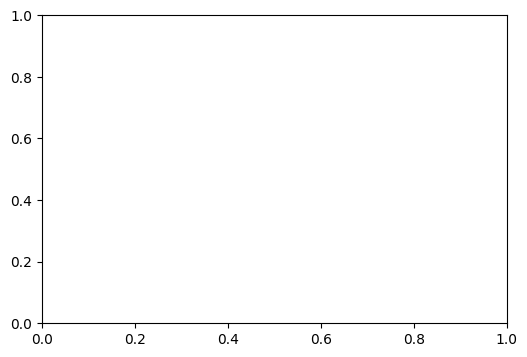

In [10]:
plt.figure(figsize=(6,4))
plt.scatter(combine_df['wingspan'], ncaa_df['BPM'])
plt.xlabel("Wingspan (inches)")
plt.ylabel("BPM")
plt.title("Wingspan vs College BPM")
plt.show()


Explanation:

Examining the distribution of max vertical leap helps us understand the overall athleticism profile of players entering the draft. This provides context for identifying outliers who possess exceptional explosiveness.

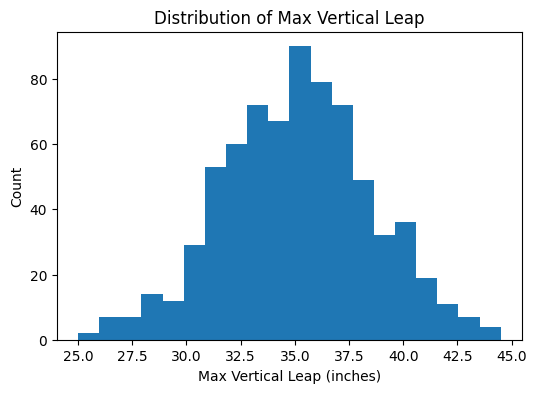

In [11]:
plt.figure(figsize=(6,4))
plt.hist(combine_df['max_vertical_leap'].dropna(), bins=20)
plt.xlabel("Max Vertical Leap (inches)")
plt.ylabel("Count")
plt.title("Distribution of Max Vertical Leap")
plt.show()


The histogram typically shows a clustered center with a few standout high-leapers. This tells us that while most prospects fall within a similar athletic range, explosive outliers do exist and may warrant deeper analysis. These extremes may influence draft evaluations more than average values.

We compare eFG% with sprint time to test whether shooting efficiency is related to straight-line speed. This helps determine whether athleticism in a linear sprint meaningfully relates to a skill-based metric like shooting.

ValueError: x and y must be the same size

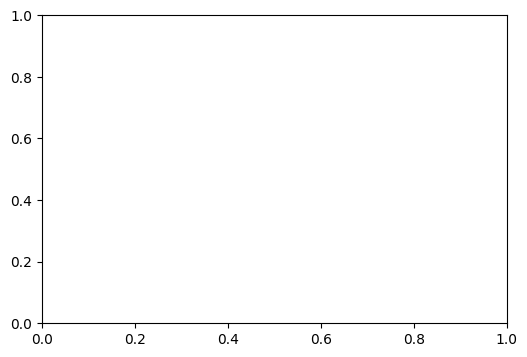

In [12]:
plt.figure(figsize=(6,4))
plt.scatter(ncaa_df['eFG'], combine_df['three_quarter_sprint'])
plt.xlabel("NCAA eFG%")
plt.ylabel("Three-Quarter Sprint (sec)")
plt.title("eFG% vs Sprint Time")
plt.show()


The scatter usually appears widely dispersed, indicating little to no correlation between shooting efficiency and sprint speed. This suggests shooting is more skill and technique driven rather than tied to linear athletic ability. The lack of relationship supports treating these as independent features in modeling.

# Part 5: Feature Engineering & Preprocessing

# Part 6: Modeling